# Classification on 20-News-Groups Dataset

# Task 1: Data Preprocessing

## Importing the second dataset: 20-News-Groups

Fetch the dataset from sklearn, choose 4 categories for classification

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.sys.mac.hardware', 'rec.sport.baseball','sci.space', 'soc.religion.christian']

news_df = fetch_20newsgroups(categories=categories, subset='train', remove=('headers','footers','quotes'))

## Reduce Space

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Convert text to word frequency vectors
vectorizer = CountVectorizer(
    stop_words='english',     # remove stopwords
    min_df=0.01,              # appear in at least 1% of documents
    max_df=0.5                # appear in at most 50% of documents
)
X_counts = vectorizer.fit_transform(news_df.data)
y = news_df.target

print("Shape of filtered word count matrix:", X_counts.shape)
print("Vocabulary size after 1%-50% filtering:", len(vectorizer.vocabulary_))


Shape of filtered word count matrix: (2367, 1226)
Vocabulary size after 1%-50% filtering: 1226


Create the final dataframe:

In [ ]:
rev_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
words = [rev_vocab[i] for i in sorted(rev_vocab)]

final_df = pd.DataFrame.sparse.from_spmatrix(X_counts, columns=words)
final_df["Target"] = y

one_hot = pd.get_dummies(final_df["Target"], prefix='y').astype(int)
final_df_enc = pd.concat([final_df.drop("Target", axis=1), one_hot], axis=1)

final_df_enc.head()


,00,000,01,04,10,100,11,12,13,14,...,year,years,yes,yesterday,york,young,y_0,y_1,y_2,y_3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Feature importance with Mutual Information (MI)

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd

# final_df_enc contains the input features + one-hot target labels
feature_cols = final_df_enc.drop(columns=['y_0', 'y_1', 'y_2', 'y_3']).columns
X_train = final_df_enc[feature_cols]

top_features_union = set()
D = 50    # 50 * 4 classes (important words might have overlap between classes)

# Loop through each class label to compute MI for each class
for class_label in ['y_0', 'y_1', 'y_2', 'y_3']:

    y_binary = final_df_enc[class_label]

    selector = SelectKBest(mutual_info_classif, k=D)  # select top D features for each class
    selector.fit(X_train, y_binary)

    selected_features = X_train.columns[selector.get_support()].tolist()
    top_features_union.update(selected_features)  # union of selected features

# Convert to sorted list
top_features_union = sorted(top_features_union)

print(f"Total unique selected features across all classes: {len(top_features_union)}")
print(top_features_union[:10])  # show a few selected features


Total unique selected features across all classes: 170
['accept', 'alomar', 'ames', 'apollo', 'apple', 'astronomy', 'average', 'ball', 'baseball', 'batting']


Dataframe with selected features

In [ ]:
XY = final_df_enc[top_features_union + ['y_0', 'y_1', 'y_2', 'y_3']]

## Train Set 20-News_Groups

In [ ]:
X_train_NG = XY.drop(['y_0', 'y_1', 'y_2', 'y_3'], axis=1)
y_train_NG = XY[['y_0', 'y_1', 'y_2', 'y_3']]

print(X_train_NG.shape)
print(y_train_NG.shape)

(2367, 170)
(2367, 4)


In [ ]:
# y_train is one-hot encoded:
y_train_labels = np.argmax(y_train_NG, axis=1)  # shape: (n_samples,)
y_train_labels

array([3, 2, 0, ..., 3, 3, 1])

## Test Set 20-News_Groups

In [ ]:
news_df_test = fetch_20newsgroups(categories=categories, subset='test', remove=('headers','footers','quotes'))

# Reduce space
X_counts_tst = vectorizer.transform(news_df_test.data)
y_tst = news_df_test.target

print("Shape of filtered word count matrix:", X_counts_tst.shape)

# create the dataframe
final_df_tst = pd.DataFrame.sparse.from_spmatrix(X_counts_tst, columns=words)
final_df_tst["Target"] = y_tst

one_hot = pd.get_dummies(final_df_tst["Target"], prefix='y').astype(int)
final_df_enc_tst = pd.concat([final_df_tst.drop("Target", axis=1), one_hot], axis=1)

final_df_enc_tst.head()


Shape of filtered word count matrix: (1574, 1226)


,00,000,01,04,10,100,11,12,13,14,...,year,years,yes,yesterday,york,young,y_0,y_1,y_2,y_3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Test dataframe with selected features

In [ ]:
XY_tst = final_df_enc_tst[top_features_union + ['y_0', 'y_1', 'y_2', 'y_3']]
XY_tst.head()

,accept,alomar,ames,apollo,apple,astronomy,average,ball,baseball,batting,...,vram,win,word,words,yankees,year,y_0,y_1,y_2,y_3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
X_test_NG = XY_tst.drop(['y_0', 'y_1', 'y_2', 'y_3'], axis=1)
y_test_NG = XY_tst[['y_0', 'y_1', 'y_2', 'y_3']]

print(X_test_NG.shape)
print(y_test_NG.shape)

(1574, 170)
(1574, 4)


In [ ]:
y_test_labels = np.argmax(y_test_NG, axis=1)  # shape: (n_samples,)

# Task 2: Implementing Multiclass Logistic Regression, KNN and Random Forest

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Pipeline setup
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression())
])

# Hyperparameter grid
param_grid = [
    {
        'model': [LogisticRegression(multi_class='multinomial', max_iter=10000)],
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__solver': ['saga']
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [1, 3, 10]
    },
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50, 100],
        'model__max_depth': [None]
    }
]

# GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_NG, y_train_labels)

# Predict and evaluate
y_pred = grid.predict(X_test_NG)

# Get the cross-validation results
cv_results = grid.cv_results_

# Extract the model names and corresponding accuracy
for i in range(len(cv_results['mean_test_score'])):
    print(f"Model: {cv_results['params'][i]}")
    print(f"Accuracy: {100*cv_results['mean_test_score'][i]:.4f} and std: {100* cv_results['std_test_score'][i]:.4f}")
    print("-" * 40)

print(f"\n Best Model: {grid.best_estimator_} \n Test Accuracy: {100 * accuracy_score(y_test_labels, y_pred):.4f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model: {'model': LogisticRegression(max_iter=10000, multi_class='multinomial'), 'model__C': 0.001, 'model__solver': 'saga'}
Accuracy: 81.5793 and std: 1.1563
----------------------------------------
Model: {'model': LogisticRegression(max_iter=10000, multi_class='multinomial'), 'model__C': 0.01, 'model__solver': 'saga'}
Accuracy: 83.0998 and std: 1.3830
----------------------------------------
Model: {'model': LogisticRegression(max_iter=10000, multi_class='multinomial'), 'model__C': 0.1, 'model__solver': 'saga'}
Accuracy: 83.7756 and std: 1.4058
----------------------------------------
Model: {'model': LogisticRegression(max_iter=10000, multi_class='multinomial'), 'model__C': 1, 'model__solver': 'saga'}
Accuracy: 84.1137 and std: 1.5440
----------------------------------------
Model: {'model': LogisticRegression(max_iter=10000, multi_class='multinomial'), 'model__C': 10, 'model__solver': 'saga'}
Accuracy: 84.1561 and std: 1.3685
----------------------------------------
Model: {'model'

# Task 3: Predictions and Comparison with ROC

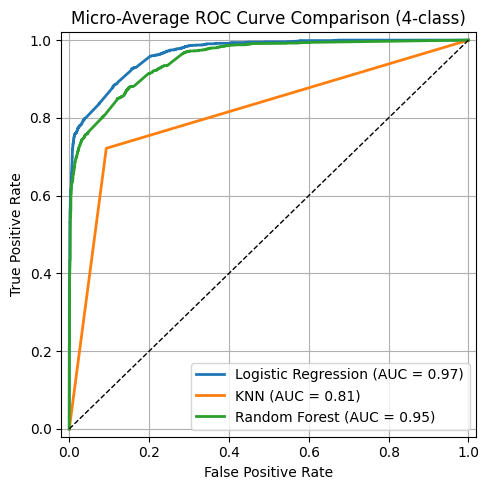

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#  Binarize the true test labels
#  y_test contains integers 0,1,2,3
y_test_bin = label_binarize(y_test_labels, classes=[0,1,2,3])
n_classes = y_test_bin.shape[1]

models = {
    'Logistic Regression': LogisticRegression(
        C=grid.best_params_['model__C'],
        #multi_class='multinomial',
        solver='saga',
        max_iter=10000
    ),
    'KNN': KNeighborsClassifier(n_neighbors = 1),
    'Random Forest': RandomForestClassifier(
        n_estimators = 50,
        max_depth = None
    )
}

plt.figure(figsize=(5, 5))

# Loop, fit, predict_proba, compute micro-average ROC & plot
for name, model in models.items():
    model.fit(X_train_NG, y_train_labels)            # train on full train set
    y_score = model.predict_proba(X_test_NG)         # shape (n_samples, n_classes)

    # Compute micro-average ROC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve Comparison (4-class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


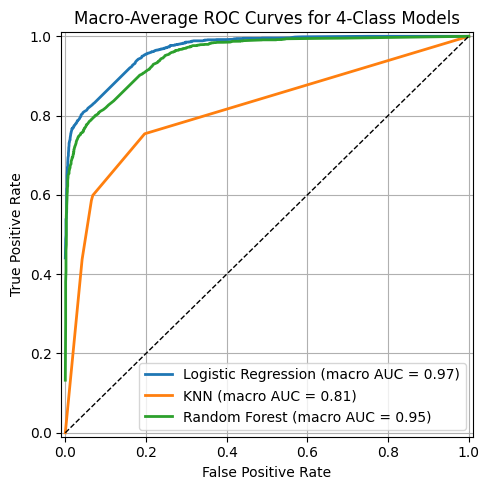

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


#  Binarize the true test labels
#  y_test contains integers 0,1,2,3
y_test_bin = label_binarize(y_test_labels, classes=[0,1,2,3])
n_classes = y_test_bin.shape[1]

models = {
    'Logistic Regression': LogisticRegression(
        C=grid.best_params_['model__C'],
     #   multi_class='multinomial',
        solver='saga',
        max_iter=10000
    ),
    'KNN': KNeighborsClassifier(n_neighbors = 1),
    'Random Forest': RandomForestClassifier(
        n_estimators = 50,
        max_depth = None
    )
}

plt.figure(figsize=(5, 5))

# Compute and plot macro-average ROC for each model
for name, model in models.items():
    model.fit(X_train_NG, y_train_labels)            # train on full train set
    y_score = model.predict_proba(X_test_NG)         # shape (n_samples, n_classes

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute all FPR points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate TPRs and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot macro-average ROC
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{name} (macro AUC = {macro_auc:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curves for 4-Class Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
